In [1]:
import pandas as pd
import numpy as np
import h5py
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from sklearn.metrics import roc_auc_score
import time
import copy
from tqdm.auto import tqdm
import torch.optim as optim
import os
import sys
import random

#trying to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
experiment_num = 13

In [4]:
#Loading data
with h5py.File('../../data/3d_array/mod_train_data_3d_h5.h5', 'r') as f:
    train_X = f['train_data_3d'][:]
with h5py.File('../../data/3d_array/mod_val_data_3d_h5.h5', 'r') as f:
    val_X = f['val_data_3d'][:]
# with h5py.File('../../data/3d_array/test_data_3d_h5.h5', 'r') as f:
#     test_X = f['test_data_3d'][:]

train_y = pd.read_parquet('../../data/3d_array/train_targets.parquet')
val_y = pd.read_parquet('../../data/3d_array/val_targets.parquet')

In [5]:
train_y['end_of_month'].value_counts()

end_of_month
2018-03-31    289115
Name: count, dtype: int64

In [6]:
train_X = np.nan_to_num(train_X, nan = 0.0)
val_X = np.nan_to_num(val_X, nan = 0.0)

In [7]:
train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]

C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_3196\639591509.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_3196\639591509.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]


In [8]:
train_y.sort_values(by=['customer_ID'])

,customer_ID,end_of_month,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-31,0
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-31,0
2,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-31,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-31,0
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2018-03-31,1
...,...,...,...
289110,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,2018-03-31,1
289111,fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6a...,2018-03-31,0
289112,ffff39cc22a375d07369980d02d617883dd28ad81a6aa3...,2018-03-31,0
289113,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-31,0


In [9]:
train_X.shape, train_y.shape

((289115, 13, 86), (289115, 3))

In [10]:
val_X.shape, val_y.shape

((32124, 13, 86), (32124, 3))

In [11]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

In [12]:
class MDC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7], num_kernels_per_scale=3):
        super(MDC, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_sizes = kernel_sizes
        self.num_scales = len(kernel_sizes)
        self.num_kernels_per_scale = num_kernels_per_scale
        self.total_kernels = self.num_scales * self.num_kernels_per_scale

        # Attention mechanism to generate weights for kernels [cite: 142, 143, 145]
        self.attention_pool = nn.AdaptiveAvgPool1d(1) # Pool across time dimension
        # Conv1d to generate temporal attention map
        self.attention_conv = nn.Conv1d(in_channels, self.total_kernels, kernel_size=1, bias=False)
        self.attention_gap = nn.AdaptiveAvgPool1d(1) # Pool attention map to get weights
        self.attention_activation = nn.Sigmoid()

        # Store the kernels for each scale and each instance per scale
        self.weights = nn.Parameter(torch.Tensor(self.total_kernels, out_channels, in_channels, 1)) # Use kernel_size=1 here, will expand later
        nn.init.kaiming_uniform_(self.weights, a=np.sqrt(5)) # Initialize weights

        # Store kernel sizes correctly
        self.k_sizes = []
        for k in kernel_sizes:
            for _ in range(num_kernels_per_scale):
                self.k_sizes.append(k)

    def forward(self, x):
        batch_size, _, T = x.size()

        # Calculate attention weights [cite: 142, 145]
        pooled_x = self.attention_pool(x) # B x C_in x 1
        # The paper's diagram (Fig 3) suggests GAP -> Conv -> GAP -> Sigmoid for attention
        # Let's follow the diagram logic more closely:
        # GAP on input: B x C_in x T -> B x C_in x 1
        att_gap1 = self.attention_pool(x)
        # Conv1d on pooled input: B x C_in x 1 -> B x total_kernels x 1 (This seems different from Fig 3's BxmxnxT output)
        # Let's reinterpret Fig 3: GAP(x) [B,Cin,T]->[B,Cin,1], then Conv [B,Cin,1]->[B,mxn,1] (This doesn't match BxmxnxT)
        # Let's try the alternative interpretation from the text (Section 3.2.1, Eq 2 implies GAP -> Conv -> GAP)
        # GAP(x) -> B x Cin x 1
        # wa * GAP(x) -> B x mxn x 1 (This still feels off from Fig 3 which applies conv before second GAP)

        # Let's follow Fig 3 literally (ignoring the first GAP shown before Conv in the Attention block):
        # Conv on input x: B x Cin x T -> B x mxn x T [cite: 143]
        attention_map = self.attention_conv(x) # B x total_kernels x T
        # GAP on attention_map: B x mxn x T -> B x mxn x 1 [cite: 145]
        attention_vector = self.attention_gap(attention_map)
        # Sigmoid activation: B x mxn x 1 [cite: 145]
        attention_weights = self.attention_activation(attention_vector) # Shape: (batch_size, total_kernels, 1)

        # Fuse kernels based on attention weights [cite: 140]
        # Reshape weights for broadcasting: (batch_size, total_kernels, 1) -> (batch_size, total_kernels, 1, 1, 1)
        # Reshape kernels: (total_kernels, out_c, in_c, 1)
        # We need to perform convolution dynamically. PyTorch doesn't easily support dynamic kernel *shapes*.
        # A common approach is to have fixed-size kernels and combine their *outputs*, or combine *weights* for a fixed kernel size.
        # The paper seems to imply combining weights *before* convolution (Eq 1). This requires all kernels w_i^j to have the same size k.
        # However, the goal is *multi-scale*.

        # Let's implement the multi-scale aspect by having separate convolutions and combining outputs weighted by attention.
        # This deviates slightly from Eq 1 but achieves the multi-scale goal.

        outputs = []
        current_kernel_idx = 0
        for k_size in self.kernel_sizes:
            padding = k_size // 2
            for i in range(self.num_kernels_per_scale):
                # Get the weights for this specific kernel instance (across all batches)
                # attention_weights shape: B x total_kernels x 1
                # kernel_weights shape: B x 1 x out_c x in_c x k_size
                kernel_idx = current_kernel_idx + i
                kernel_weight = self.weights[kernel_idx] # out_c x in_c x 1
                # Manually create the kernel for Conv1d for this size
                dynamic_kernel = kernel_weight.repeat(1, 1, k_size) # out_c x in_c x k_size
                
                # Perform convolution with this specific kernel
                output_i = F.conv1d(x, dynamic_kernel, padding=padding) # B x out_c x T
                
                # Apply attention weight for this kernel
                # attention_weights[:, kernel_idx, :] shape: B x 1 x 1
                weighted_output = output_i * attention_weights[:, kernel_idx, :].unsqueeze(-1) # B x out_c x T
                outputs.append(weighted_output)
                
            current_kernel_idx += self.num_kernels_per_scale

        # Sum the weighted outputs from all kernels
        # This is an alternative interpretation to fusing weights first.
        out = torch.sum(torch.stack(outputs), dim=0) # B x out_c x T

        return out

In [13]:
class MDCResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7], num_kernels_per_scale=3, stride=1):
        super(MDCResBlock, self).__init__()
        
        # Use Conv1d for the residual connection if dimensions change
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.mdc1 = MDC(in_channels, out_channels, kernel_sizes, num_kernels_per_scale)
        self.bn1 = nn.BatchNorm1d(out_channels)
        # Paper uses PReLU, let's use ReLU for simplicity or add PReLU if needed. Using PReLU as per paper.
        self.prelu1 = nn.PReLU(out_channels)

        self.mdc2 = MDC(out_channels, out_channels, kernel_sizes, num_kernels_per_scale)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.prelu2 = nn.PReLU(out_channels) # Activation after final BN before adding shortcut

    def forward(self, x):
        shortcut = self.shortcut(x)

        out = self.mdc1(x)
        out = self.bn1(out)
        out = self.prelu1(out)

        out = self.mdc2(out)
        out = self.bn2(out)

        out += shortcut
        out = self.prelu2(out) # Final activation after adding shortcut

        return out

In [14]:
class MDCNet(nn.Module):
    def __init__(self, input_channels, num_classes, block_channels=[128, 128, 128], kernel_sizes=[3,5,7], num_kernels_per_scale=2, dropout_rate=0.3, reduction=16):
        super(MDCNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        current_channels = input_channels
        
        # Configuration from paper/Figure 2: 3 Blocks [cite: 130]
        # Each block: MDC ResBlock -> MaxPool -> SE -> Dropout
        for i, channels in enumerate(block_channels):
            # Stride only applied if pooling happens, MaxPooling handles stride=2
            res_block = MDCResBlock(current_channels, channels, kernel_sizes, num_kernels_per_scale, stride=1)
            max_pool = nn.MaxPool1d(kernel_size=2, stride=2) # Halve the length [cite: 132]
            se_block = SEBlock(channels, reduction) # SE block [cite: 133]
            dropout = nn.Dropout(dropout_rate) # Dropout [cite: 134]
            
            block = nn.Sequential(
                res_block,
                max_pool,
                se_block,
                dropout
            )
            self.blocks.append(block)
            current_channels = channels # Update channels for next block

        self.gap = nn.AdaptiveAvgPool1d(1) # Global Average Pooling [cite: 130]
        # The original ConvModel in experiment_10 has FC layers after pooling.
        # MDCNet in the paper feeds features to DPNet or directly to Softmax.
        # To make it a component usable in the existing structure, we output features before FC layers.
        self.output_channels = current_channels

    def forward(self, x):
        # Input x shape: B x T x C_in (e.g., B x 10 x 115)
        # Conv1D expects B x C_in x T
        x = x.permute(0, 2, 1) # B x C_in x T (e.g., B x 115 x 10)

        for block in self.blocks:
            x = block(x)

        # Global Average Pooling
        x = self.gap(x) # B x C_out x 1
        x = x.view(x.size(0), -1) # Flatten: B x C_out

        return x

In [15]:
class ModifiedConvModel(nn.Module):
    def __init__(self, input_size, time_steps, num_classes=1, mdc_block_channels=[64, 64, 64], mdc_kernel_sizes=[3,5,7], mdc_kernels_per_scale=2, dropout_rate=0.2, fc_size=32):
        super(ModifiedConvModel, self).__init__()
        
        # Instantiate MDCNet feature extractor
        self.mdc_net = MDCNet(input_channels=input_size,
                              num_classes=num_classes, # Not directly used by MDCNet output layer here
                              block_channels=mdc_block_channels,
                              kernel_sizes=mdc_kernel_sizes,
                              num_kernels_per_scale=mdc_kernels_per_scale,
                              dropout_rate=dropout_rate)
        
        # Get the output feature dimension from MDCNet
        mdc_output_channels = self.mdc_net.output_channels

        # Fully connected layers (similar to original experiment_10)
        self.fc1 = nn.Linear(mdc_output_channels, fc_size)
        self.relu_fc = nn.ReLU() # Added ReLU after FC1
        self.fc2 = nn.Linear(fc_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x time_steps x features
        
        # Pass through MDCNet feature extractor
        features = self.mdc_net(x) # Output: B x mdc_output_channels
        
        # Fully connected layers
        x = self.fc1(features)
        x = self.relu_fc(x)
        x = self.fc2(x)
        
        # Output probability
        return self.sigmoid(x)

In [16]:
# Initialize the Modified ConvModel
input_size = train_X.shape[2]  # Number of features (115)
time_steps = train_X.shape[1]  # Number of time steps (10)
output_size = 1  # Binary classification

In [17]:
# --- MDCNet Hyperparameters ---
# Using smaller channels than paper's example for potentially faster training/less memory
mdc_block_channels = [16, 32, 64] # Example channel sizes for each block
# Using kernel sizes mentioned in paper, and n=2 as found via cross-validation in paper [cite: 242, 243]
mdc_kernel_sizes = [3, 5, 7]
mdc_kernels_per_scale = 2
dropout_rate = 0.2 # Adjusted dropout
fc_size = 16 # Adjusted FC size

# Create model instance
model = ModifiedConvModel(input_size=input_size,
                          time_steps=time_steps,
                          num_classes=output_size,
                          mdc_block_channels=mdc_block_channels,
                          mdc_kernel_sizes=mdc_kernel_sizes,
                          mdc_kernels_per_scale=mdc_kernels_per_scale,
                          dropout_rate=dropout_rate,
                          fc_size=fc_size)

print(f"Model initialized with input_size={input_size}, output_size={output_size}")

Model initialized with input_size=86, output_size=1


In [ ]:
batch_size = 2048
from torchinfo import summary
summary(model, input_size=(batch_size, train_X.shape[1], train_X.shape[2]), device='cpu',
        col_names=["input_size", "output_size", "num_params", "mult_adds"], depth=3) # Increased depth to see inside MDCNet

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
ModifiedConvModel                                       [2048, 13, 86]            [2048, 1]                 --                        --
├─MDCNet: 1-1                                           [2048, 13, 86]            [2048, 64]                --                        --
│    └─ModuleList: 2-1                                  --                        --                        --                        --
│    │    └─Sequential: 3-1                             [2048, 86, 13]            [2048, 16, 6]             11,940                    53,256,192
│    │    └─Sequential: 3-2                             [2048, 16, 6]             [2048, 32, 3]             10,400                    10,616,832
│    │    └─Sequential: 3-3                             [2048, 32, 3]             [2048, 64, 1]             40,512                    18,219,008
│    └─Ada

In [19]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [20]:
train_dataset = TimeSeriesDataset(train_X, train_y['target'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
val_dataset = TimeSeriesDataset(val_X, val_y['target'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
train_dataset.__getitem__(0)[0].shape, train_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([0.]))

In [23]:
val_dataset.__getitem__(0)[0].shape, val_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([1.]))

In [24]:
from sklearn.metrics import roc_auc_score
import time
import copy
from tqdm.auto import tqdm

import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20 # Adjust as needed
patience = 3  # Early stopping patience

# Initialize variables for early stopping
best_val_loss = float('inf')
best_val_auc = 0.0
best_model_wts = copy.deepcopy(model.state_dict()) # Use state_dict()
no_improve_epochs = 0

# For tracking metrics
train_losses = []
val_losses = []
val_aucs = []

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Training on {device}")
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = running_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    all_preds = [p[0] for p in all_preds]
    all_labels = [l[0] for l in all_labels]
    # Handle case where validation set might only have one class temporarily during testing/debugging
    if len(np.unique(all_labels)) > 1:
        epoch_val_auc = roc_auc_score(all_labels, all_preds)
    else:
        epoch_val_auc = 0.0 # Or handle as appropriate, e.g., skip AUC calculation
    val_aucs.append(epoch_val_auc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val AUC: {epoch_val_auc:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_val_auc = epoch_val_auc
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Training complete
time_elapsed = time.time() - start_time
print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
print(f"Best val loss: {best_val_loss:.4f}, Best val AUC: {best_val_auc:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Training on cuda:0


Epoch 1/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 1/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 0.3507, Val Loss: 0.3300, Val AUC: 0.9348


Epoch 2/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 2/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 0.2818, Val Loss: 0.2752, Val AUC: 0.9413


Epoch 3/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 3/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 0.2697, Val Loss: 0.2748, Val AUC: 0.9455


Epoch 4/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 4/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 0.2639, Val Loss: 0.2805, Val AUC: 0.9472


Epoch 5/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 5/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.2602, Val Loss: 0.2519, Val AUC: 0.9490


Epoch 6/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 6/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.2570, Val Loss: 0.2673, Val AUC: 0.9488


Epoch 7/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 7/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.2554, Val Loss: 0.2515, Val AUC: 0.9501


Epoch 8/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 8/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.2534, Val Loss: 0.2495, Val AUC: 0.9505


Epoch 9/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 9/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.2518, Val Loss: 0.2688, Val AUC: 0.9497


Epoch 10/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 10/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.2508, Val Loss: 0.2466, Val AUC: 0.9509


Epoch 11/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 11/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.2494, Val Loss: 0.2474, Val AUC: 0.9510


Epoch 12/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 12/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.2495, Val Loss: 0.2532, Val AUC: 0.9512


Epoch 13/20 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 13/20 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.2480, Val Loss: 0.2506, Val AUC: 0.9513
Early stopping triggered after 13 epochs
Training completed in 1m 53s
Best val loss: 0.2466, Best val AUC: 0.9509


<All keys matched successfully>

In [25]:
import os

# Save the model weights

# Create directory if it doesn't exist
save_dir = '../../models/deep_learning'
os.makedirs(save_dir, exist_ok=True)

# Save model state dictionary
model_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
torch.save(model.state_dict(), model_path)

# Save additional information for later reference
checkpoint_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(checkpoint, checkpoint_path)

print(f"Model saved to {model_path}")
print(f"Checkpoint saved to {checkpoint_path}")

Model saved to ../../models/deep_learning\experiment_13.pth
Checkpoint saved to ../../models/deep_learning\experiment_13.pth


Validation predictions obtained.
Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.6999279
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8537    0.9800    0.9125     23806
     Class 1     0.9008    0.5194    0.6588      8318

    accuracy                         0.8607     32124
   macro avg     0.8772    0.7497    0.7857     32124
weighted avg     0.8659    0.8607    0.8468     32124



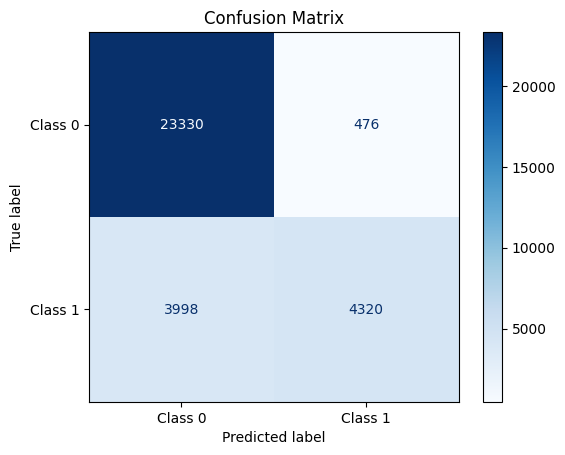

0.6999279260635376

In [27]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize a list to store predictions
val_predictions = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        val_predictions.extend(outputs.cpu().numpy())

# Flatten the predictions
val_predictions = [p[0] for p in val_predictions]
print("Validation predictions obtained.")

from utils.eval_helpers import evaluate_model_for_recall
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=np.array(all_labels).astype('int'), y_pred_proba=np.array(val_predictions))